In [1]:
# Params
EPOCHS = 50
BATCH_SIZE = 32
SHUFFLE = True
IMAGE_SIZE = (150, 150)

# Data Loading

In [2]:
# Ignoring warnings
import warnings
warnings.simplefilter("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os

# Changing Current Working directory
project_path = r"/content/drive/MyDrive/project"
os.chdir(project_path)

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# No augmentation for testing data, only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

2024-07-21 16:15:32.393918: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-21 16:15:32.394036: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-21 16:15:32.536655: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# Data paths
train_dir = 'data/Training'
test_dir = 'data/Testing'

# Training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=SHUFFLE
)

# Testing data
validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=SHUFFLE
)

In [5]:
import numpy as np
from tensorflow.keras.utils import Sequence

class MultiInputDataGenerator(Sequence):
    def __init__(self, generator, batch_size):
        self.generator = generator
        self.batch_size = batch_size

    def __len__(self):
        return len(self.generator)

    def __getitem__(self, index):
        batch_x, batch_y = self.generator[index]
        return (batch_x, batch_x), batch_y

    def on_epoch_end(self):
        self.generator.on_epoch_end()

# Custom data generators for dual input
train_multi_input_gen = MultiInputDataGenerator(train_generator, batch_size=BATCH_SIZE)
val_multi_input_gen = MultiInputDataGenerator(validation_generator, batch_size=BATCH_SIZE)

# Data Analysis

In [6]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Function to count files in each directory
def count_files(directory):
    class_counts = {}
    for class_dir in os.listdir(directory):
        class_path = os.path.join(directory, class_dir)
        class_counts[class_dir] = len(os.listdir(class_path))
    return class_counts

# Count files in training and testing directories
train_counts = count_files(train_dir)
test_counts = count_files(test_dir)

# Plotting class distributions with Pie charts
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]],
                    subplot_titles=['Training Data Class Distribution', 'Testing Data Class Distribution'])

fig.add_trace(go.Pie(labels=list(train_counts.keys()), values=list(train_counts.values()), name="Training"),
              1, 1)
fig.add_trace(go.Pie(labels=list(test_counts.keys()), values=list(test_counts.values()), name="Testing"),
              1, 2)
fig.show()

In [7]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

# Function to get image sizes
def get_image_sizes(directory):
    sizes = []
    for class_dir in os.listdir(directory):
        class_path = os.path.join(directory, class_dir)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            with Image.open(img_path) as img:
                sizes.append(img.size)
    return sizes

# Get image sizes
train_sizes = get_image_sizes(train_dir)
test_sizes = get_image_sizes(test_dir)

In [8]:
import plotly.express as px

# Convert to DataFrame for easy plotting
train_sizes_df = pd.DataFrame(train_sizes, columns=['Width', 'Height'])
test_sizes_df = pd.DataFrame(test_sizes, columns=['Width', 'Height'])

# Plotting image sizes using Plotly
fig_train = px.scatter(train_sizes_df, x='Width', y='Height', title='Training Data Image Sizes')
fig_train.update_layout(width=800)
fig_train.show()

fig_test = px.scatter(test_sizes_df, x='Width', y='Height', title='Testing Data Image Sizes')
fig_test.update_layout(width=800)
fig_test.show()

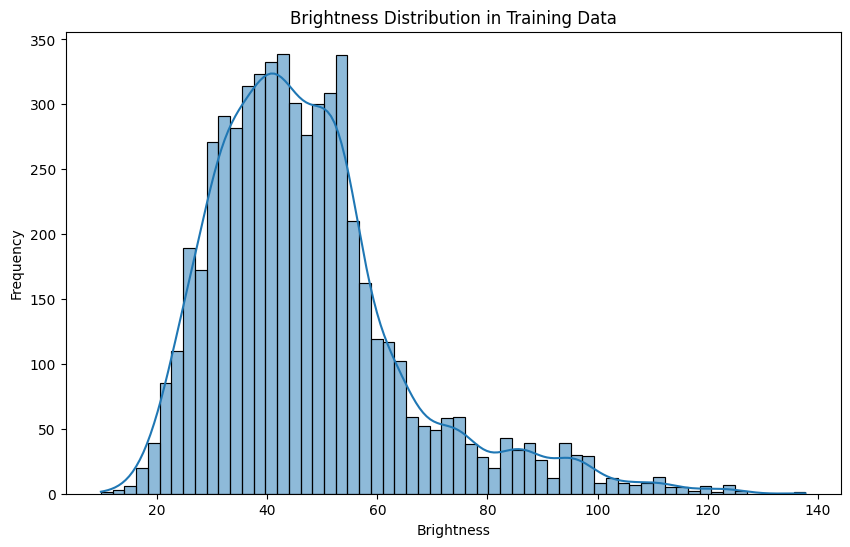

In [9]:
# Function to calculate image birghtness
def calculate_brightness(image):
    img = np.array(image)
    return np.mean(img)

# Analyze brightness
train_brightness = []
for class_dir in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_dir)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        with Image.open(img_path) as img:
            train_brightness.append(calculate_brightness(img))

# Plot brightness distribution
plt.figure(figsize=(10, 6))
sns.histplot(train_brightness, kde=True)
plt.title('Brightness Distribution in Training Data')
plt.xlabel('Brightness')
plt.ylabel('Frequency')
plt.show()

In [10]:
# Check normalization
batch = next(train_generator)
print(f'Batch shape: {batch[0].shape}')
print(f'Min pixel value: {batch[0].min()}')
print(f'Max pixel value: {batch[0].max()}')

# Ensure labels are encoded correctly
print(f'Class indices: {train_generator.class_indices}')

# Get file paths and labels
train_file_paths = []
train_labels = []
for class_dir in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_dir)
    for img_name in os.listdir(class_path):
        train_file_paths.append(os.path.join(class_path, img_name))
        train_labels.append(class_dir)

# Class weights
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights))
print(f'Class weights: {class_weights}')

Batch shape: (32, 150, 150, 3)
Min pixel value: 0.0
Max pixel value: 1.0
Class indices: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Class weights: {0: 1.080999242997729, 1: 1.0664675130694548, 2: 0.8952978056426333, 3: 0.9800960878517502}


# Modeling

## a) Model Designing

In [23]:
from tensorflow.keras.applications import VGG16, InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, concatenate, BatchNormalization, GlobalAveragePooling2D

def create_pretrained_model_1(input_shape):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
    for layer in base_model.layers[:10]:
        layer.trainable = True
        
    for layer in base_model.layers[10:]:
        layer.trainable = False
        
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    return base_model.input, x

def create_pretrained_model_2(input_shape):
    
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    
    for layer in base_model.layers[:10]:
        layer.trainable = True
        
    for layer in base_model.layers[10:]:
        layer.trainable = False
        
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    return base_model.input, x

def create_hybrid_model(input_shape):
    input_1, output_1 = create_pretrained_model_1(input_shape)
    input_2, output_2 = create_pretrained_model_2(input_shape)

    combined = concatenate([output_1, output_2])
    z = Dense(256, activation='relu')(combined)
    z = Dropout(0.5)(z)
    z = Dense(4, activation='softmax')(z)

    model = Model(inputs=[input_1, input_2], outputs=z)
    return model

input_shape = (150, 150, 3)
hybrid_model = create_hybrid_model(input_shape)
# hybrid_model.summary()

In [34]:
# from tensorflow.keras.utils import plot_model
# plot_model(hybrid_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# # Display the plot
# from IPython.display import Image
# Image(filename='model_plot.png')

In [25]:
# Compile the model
hybrid_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## b) Model Training

In [26]:
# Callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

callbacks = [checkpoint, early_stopping]

In [27]:
# Train the model
history = hybrid_model.fit(
    train_multi_input_gen,
#     steps_per_epoch=len(train_multi_input_gen),
    validation_data=val_multi_input_gen,
#     validation_steps=len(val_multi_input_gen),
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/50


2024-07-21 16:34:45.516969: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.18794, expected 3.54228
2024-07-21 16:34:45.517026: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 5.14647, expected 4.50081
2024-07-21 16:34:45.517040: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 5.30074, expected 4.65509
2024-07-21 16:34:45.517057: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 4.91575, expected 4.27009
2024-07-21 16:34:45.517072: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10: 3.57367, expected 2.92801
2024-07-21 16:34:45.517083: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 11: 4.05899, expected 3.41334
2024-07-21 16:34:45.517094: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 5.27592, expected 4.63026
2024-07-21 16:34:45.517105: E external/local_xla/xla

  1/179 ━━━━━━━━━━━━━━━━━━━━ 2:32:45 51s/step - accuracy: 0.3750 - loss: 2.9405

I0000 00:00:1721579718.051428      95 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


122/179 ━━━━━━━━━━━━━━━━━━━━ 14s 252ms/step - accuracy: 0.4761 - loss: 1.5709

2024-07-21 16:35:53.858499: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 13949: 2.55788, expected 2.19131
2024-07-21 16:35:53.858684: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 45000: 4.27818, expected 3.64025
2024-07-21 16:35:53.858694: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 45002: 5.33515, expected 4.69721
2024-07-21 16:35:53.858702: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 45003: 4.90498, expected 4.26705
2024-07-21 16:35:53.858709: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 45009: 4.74986, expected 4.11192
2024-07-21 16:35:53.858717: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 45010: 4.24757, expected 3.60963
2024-07-21 16:35:53.858725: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 45011: 4.15995, expected 3.52201
2024-07-21 16:35:53.858732:

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.5176 - loss: 1.4022

2024-07-21 16:36:42.766595: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.42672, expected 2.89379
2024-07-21 16:36:42.766656: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 4.23595, expected 3.70302
2024-07-21 16:36:42.766666: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 3.86374, expected 3.33082
2024-07-21 16:36:42.766674: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 11: 2.7529, expected 2.21998
2024-07-21 16:36:42.766682: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 26: 3.98882, expected 3.4559
2024-07-21 16:36:42.766690: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 30: 3.66189, expected 3.12897
2024-07-21 16:36:42.766697: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31: 4.02495, expected 3.49202
2024-07-21 16:36:42.766705: E external/local_xla/xla/

179/179 ━━━━━━━━━━━━━━━━━━━━ 151s 559ms/step - accuracy: 0.5183 - loss: 1.3998 - val_accuracy: 0.6095 - val_loss: 1.2449
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 51s 273ms/step - accuracy: 0.7549 - loss: 0.6865 - val_accuracy: 0.7376 - val_loss: 0.6577
Epoch 3/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 50s 268ms/step - accuracy: 0.8026 - loss: 0.5566 - val_accuracy: 0.7559 - val_loss: 0.6711
Epoch 4/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 50s 267ms/step - accuracy: 0.8110 - loss: 0.5442 - val_accuracy: 0.7346 - val_loss: 0.7024
Epoch 5/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 51s 272ms/step - accuracy: 0.8284 - loss: 0.4939 - val_accuracy: 0.8246 - val_loss: 0.4978
Epoch 6/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 51s 274ms/step - accuracy: 0.8260 - loss: 0.4969 - val_accuracy: 0.8391 - val_loss: 0.4181
Epoch 7/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 50s 267ms/step - accuracy: 0.8368 - loss: 0.4585 - val_accuracy: 0.8040 - val_loss: 0.5318
Epoch 8/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 49s 262ms/step - accuracy: 0.8403 - loss: 0.4466 - va

In [28]:
# Saving final model
hybrid_model.save("trained_model.keras")

## c) Model Evaluation

In [29]:
from tensorflow.keras.models import load_model
model = load_model("/kaggle/working/best_model.keras")

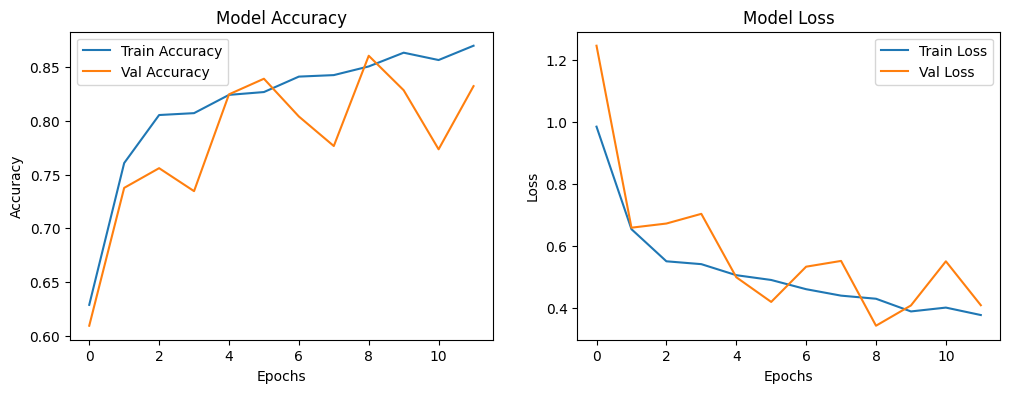

In [30]:
# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

plot_history(history)

In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Reset the validation generator
val_multi_input_gen.on_epoch_end()

# Initialize lists to store validation images and labels
val_images_all = []
val_labels_all = []

# Fetch all validation data
for i in range(len(val_multi_input_gen)):
    (val_images, _), val_labels = val_multi_input_gen[i]
    val_images_all.append(val_images)
    val_labels_all.append(val_labels)

# Convert lists to numpy arrays
val_images_all = np.vstack(val_images_all)
val_labels_all = np.vstack(val_labels_all)

# Make predictions
val_preds = hybrid_model.predict([val_images_all, val_images_all])
val_preds_classes = np.argmax(val_preds, axis=1)
val_true_classes = np.argmax(val_labels_all, axis=1)

# Calculate metrics
accuracy = accuracy_score(val_true_classes, val_preds_classes)
precision = precision_score(val_true_classes, val_preds_classes, average='weighted')
recall = recall_score(val_true_classes, val_preds_classes, average='weighted')
f1 = f1_score(val_true_classes, val_preds_classes, average='weighted')
class_report = classification_report(val_true_classes, val_preds_classes, target_names=train_generator.class_indices.keys())
conf_matrix = confusion_matrix(val_true_classes, val_preds_classes)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print('Classification Report:')
print(class_report)
print('Confusion Matrix:')
print(conf_matrix)

41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 197ms/step
Accuracy: 0.8604118993135011
Precision: 0.8613983433140754
Recall: 0.8604118993135011
F1 Score: 0.8577426730254855
Classification Report:
              precision    recall  f1-score   support

      glioma       0.94      0.78      0.85       300
  meningioma       0.75      0.70      0.72       306
     notumor       0.90      0.97      0.93       405
   pituitary       0.84      0.96      0.90       300

    accuracy                           0.86      1311
   macro avg       0.86      0.85      0.85      1311
weighted avg       0.86      0.86      0.86      1311

Confusion Matrix:
[[234  56   1   9]
 [ 11 214  40  41]
 [  2   7 392   4]
 [  2   8   2 288]]


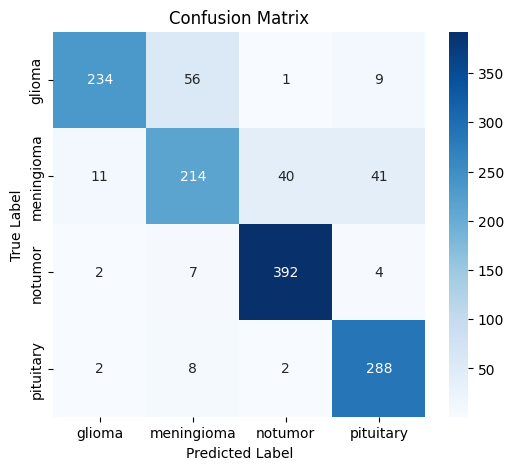

In [38]:
# Plot confusion matrix
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

plot_confusion_matrix(conf_matrix, list(train_generator.class_indices.keys()))

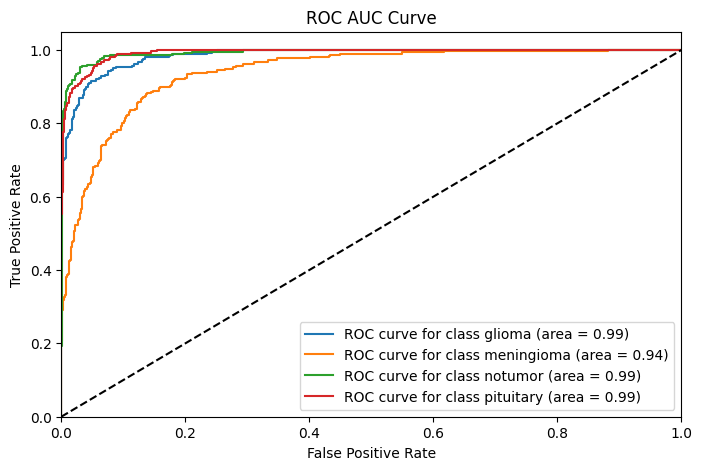

In [40]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the true classes for ROC curve
val_labels_binarized = label_binarize(val_true_classes, classes=[0, 1, 2, 3])

# Plot ROC AUC curve
def plot_roc_auc_curve(y_true, y_pred, classes):
    plt.figure(figsize=(8, 5))
    for i in range(len(classes)):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'ROC curve for class {classes[i]} (area = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC Curve')
    plt.legend(loc='lower right')
    plt.show()

plot_roc_auc_curve(val_labels_binarized, val_preds, list(train_generator.class_indices.keys()))

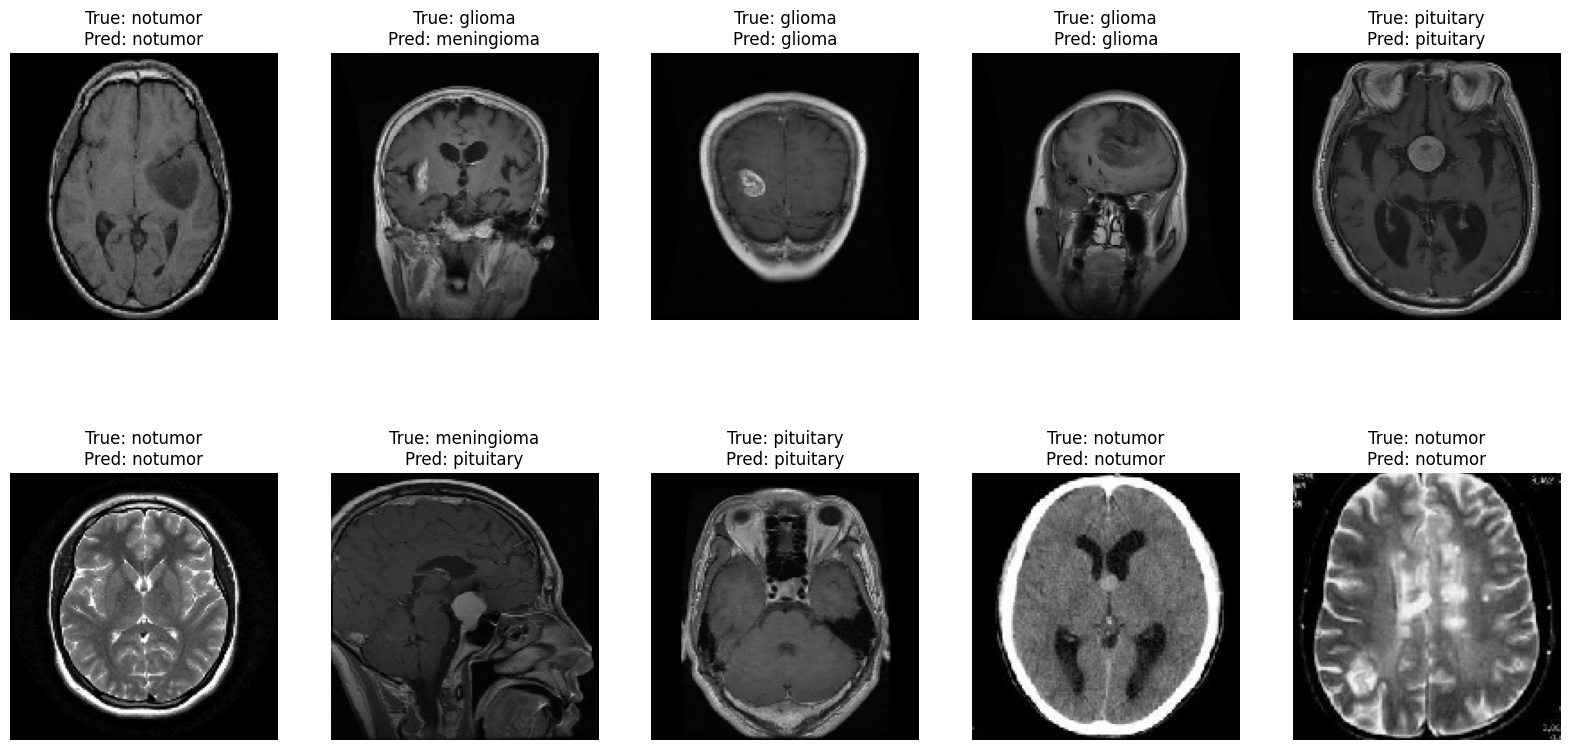

In [41]:
import random

# Plot random samples with actual and predicted labels
def plot_random_samples(images, true_labels, pred_labels, class_names, n=10):
    plt.figure(figsize=(20, 10))
    indices = random.sample(range(len(images)), n)
    for i, idx in enumerate(indices):
        plt.subplot(2, n//2, i+1)
        plt.imshow(images[idx])
        true_class = class_names[true_labels[idx]]
        pred_class = class_names[pred_labels[idx]]
        plt.title(f'True: {true_class}\nPred: {pred_class}')
        plt.axis('off')
    plt.show()

class_names = list(train_generator.class_indices.keys())
plot_random_samples(val_images_all, val_true_classes, val_preds_classes, class_names)

In [42]:
class_names

['glioma', 'meningioma', 'notumor', 'pituitary']